In [3]:
# !pip install /kaggle/input/uspto-whoosh-reloaded-2-7-5-patched/Whoosh_Reloaded-2.7.5-py2.py3-none-any.whl
!pip install TorchCRF
!pip install pytorch-crf
!pip install evaluate
# !pip install Keras-Preprocessing
# !pip install tf

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
!sed 's:/kaggle/input/whoosh-wheel-2-7-4/Whoosh-2.7.4-py2.py3-none-any.whl:whoosh-reloaded==2.7.5:g' /kaggle/input/whoosh-utils/whoosh_utils.py > whoosh_utils.py

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import ast
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import get_cosine_schedule_with_warmup, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig, DataCollatorWithPadding,  DataCollatorForTokenClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

from tqdm import tqdm
from os.path import join as jp
input_path = '/kaggle/input'
uspto_path = 'uspto-explainable-ai'
after1975_path = 'uspto-all-patents-after-1975'
_ = jp(input_path, uspto_path)
_1975 = jp(input_path, after1975_path)

In [ ]:
pm_df.head(10)

In [ ]:
pd_example_df = pd.read_parquet(jp(_, 'patent_data', '1838_10.parquet'))

In [ ]:
pd_example_df.head()

In [ ]:
import whoosh.index as indds
print(jp(_, 'train_index'))
ix = indds.open_dir(jp(_, 'train_index'))

In [ ]:
qp = QueryParser("content", schema=myindex.schema)
q = qp.parse(u"")
with myindex.searcher() as s:
    results = s.search(q)

In [ ]:
!pip install accelerate

In [ ]:
!pip install --upgrade --force-reinstall https://pypi.org/simple/ bitsandbytes

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig

In [ ]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/gemma/transformers/1.1-2b-it/1/",
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/1.1-2b-it/1/")

In [ ]:
from torch.nn import Linear
from torch import nn
device = torch.device('cuda')

In [ ]:
n_modules = {}
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Linear) and ('mlp' in name):
#         parent_module = model
#         for n in name.split('.')[:-1]:
#             parent_module = getattr(parent_module, n)
        
        W = layer.weight.data
        U, S, V = torch.svd(W)
        
        n = W.shape[0]
        m = W.shape[1]
        # Choose the rank for approximation
        rank = int(((n * m) / (n+m)) * 0.9)  # You can adjust this based on the required approximation quality

        # Approximate the weight matrix using the first 'rank' singular values
        print(len(S))
        has_bias = layer.bias is not None
        S_diag = torch.diag(S[:rank])
        U_approx = U[:, :rank].to(device)
        V_approx = torch.mm(S_diag, V[:, :rank].t()).to(device) 
        print(S)
        print(W, U_approx @ V_approx)
        
        linear_layer1 = Linear(U_approx.shape[1], U_approx.shape[0], bias=False)
        linear_layer1.weight.data = U_approx
        if has_bias: 
            linear_layer1.bias.data = layer.bias.data
        

        # Define the second Linear4bit layer with the appropriate dimensions
        
        linear_layer2 = Linear(V_approx.shape[1], V_approx.shape[0], bias=has_bias)
        linear_layer2.weight.data = V_approx
        
        
        n_module = nn.Sequential(linear_layer2, linear_layer1)
        n_modules[name] = n_module
        print(name, type(layer), n_module)
        del layer
        
#         print(n_module(torch.zeros((1, U_approx.shape[0])).to(device)))
#         # Optionally, set the bias terms if they are required
#         if linear_layer.bias is not None:
#             linear_layer1.bias.data = linear_layer.bias.data[:rank]
#             linear_layer2.bias.data = linear_layer.bias.data[rank:]
#         setattr(parent_module, name, n_module)
            
        torch.cuda.empty_cache()
print(n_modules)

In [ ]:
for name, layer in n_modules.items():
    print(name, layer)
    parent_module = model
    for n in name.split('.')[:-1]:
        parent_module = getattr(parent_module, n)
    setattr(parent_module, name.split('.')[-1], layer)
        

In [ ]:
model.model.embed_tokens(torch.zeros((1, 256000), dtype=torch.int32))

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda')

In [ ]:
gen_conf = GenerationConfig(
max_new_tokens = 500.0,
# temperature=100.0,
# do_sample=True,
# top_k=10
)

In [ ]:
input_text = "Tell me story about blue balls"
input_ids = tokenizer(input_text, return_tensors="pt").to(device)
outputs = model.generate(**input_ids, generation_config=gen_conf)
print(tokenizer.decode(outputs[0]))

# CRF experiment

In [5]:
batch_size = 2

In [6]:
def load_data(data_path):
    df = pd.read_csv(data_path)
    df.dropna(inplace=True)
    print("Number of records: ", len(df))
    return df

def preprocess_data(df):
    for i in range(len(df)):
        pos = ast.literal_eval(df['POS'][i])
        tags = ast.literal_eval(df['Tag'][i])
        df.loc[i, 'POS'] = [str(word) for word in pos]
        df.loc[i, 'Tag'] = [str(word.upper()) for word in tags]
    return df

df = load_data(r'/kaggle/input/named-entity-recognition-ner-corpus/ner.csv')
df = preprocess_data(df)
print(df.head(1))
df_final = df[['Sentence', 'Tag']]

Number of records:  47959
    Sentence #                                           Sentence  \
0  Sentence: 1  Thousands of demonstrators have marched throug...   

                                                 POS  \
0  [NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...   

                                                 Tag  
0  [O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...  


In [7]:
def check_for_word(string):
    return re.search('[a-zA-Z0-9]', string) is not None
def get_word_alignment(tokens, tokenizer):
    alignment = [0] * len(tokens)
    word_num = 1
    was_space = False
    for i, chars in enumerate(tokenizer.batch_decode(tokens)):
        if chars == '<bos>':
            alignment[i] = 0
            continue
        if check_for_word(chars):
            spaces = chars.count(' ')
            if spaces > 0:
                was_space = True
            if was_space:
                word_num += 1
                was_space = False
            alignment[i] = word_num
        else:
#             if chars != '-':
            was_space = True
            alignment[i] = 0    
#         print(chars, alignment[i].item())
    return alignment

In [8]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/gemma/transformers/1.1-2b-it/1/")
tokens_inds = tokenizer(df_final['Sentence'].to_list())

In [9]:
word_align = []
for tokens in tqdm(tokens_inds['input_ids']):
    word_align.append(get_word_alignment(tokens, tokenizer))

100%|██████████| 47959/47959 [00:21<00:00, 2192.77it/s]


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df_final['Tag'].to_list(), )
tgt_int = tag_tokenizer.texts_to_sequences(df_final['Tag'].to_list())
tgt_int = [[tgt - 1 for tgt in t] for t in tgt_int]

In [11]:
df_final['Tokens'] = pd.Series(tokens_inds['input_ids'], index=df_final.index)
df_final['Alignment'] = pd.Series(word_align, index=df_final.index)
df_final['Attn_mask'] = pd.Series(tokens_inds['attention_mask'], index=df_final.index)
df_final['Tag_int'] = pd.Series(tgt_int, index=df_final.index)

/tmp/ipykernel_34/475732328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Tokens'] = pd.Series(tokens_inds['input_ids'], index=df_final.index)


In [ ]:
df_final.head()

In [ ]:
print(tag_tokenizer.index_word)

In [12]:
class NerDataset(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.tag = dataframe["Tag_int"]
        
#         self.sentence = dataframe["Sentence"]
        self.tokens = dataframe["Tokens"]
        self.alignment = dataframe["Alignment"]
        self.attn_mask = dataframe["Attn_mask"]
        self.crf_mask = []
        for t, a in zip(self.tokens, self.alignment):
            mask = torch.tensor([1]*max(a)+ [0] * (len(t)-max(a)), dtype=torch.uint8)
            self.crf_mask.append(mask)
            
        for i, (t, tag) in enumerate(zip(self.tokens, self.tag)):
            if len(tag) > len(t):
                self.tag[i] = tag[:len(t)]
            elif len(tag) < len(t):
                self.tag[i] += [0] * (len(t)-len(tag))
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        tag = self.tag.iloc[idx]
#         sentence = self.sentence.iloc[idx]
        tokens = self.tokens.iloc[idx]
        alignment = self.alignment.iloc[idx]
        attn_mask = self.attn_mask.iloc[idx]
        crf_mask = self.crf_mask[idx]
        return {'tag': torch.tensor(tag), 'input_ids': torch.tensor(tokens), 'alignment': torch.tensor(alignment),'attn_mask': torch.tensor(attn_mask), 'crf_mask': torch.tensor(crf_mask)}


In [13]:
dataset = NerDataset(df_final)

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
p=0.8
def change_true_to_false(tensor, p):
    flat_tensor = tensor.flatten()
    true_indices = torch.nonzero(flat_tensor, as_tuple=False).flatten()
    num_true_to_change = int(len(true_indices) * p)
    
    if num_true_to_change > 0:
        selected_indices = true_indices[torch.randperm(len(true_indices))[:num_true_to_change]]
        flat_tensor[selected_indices] = False
        
    return flat_tensor.view(tensor.shape)

In [16]:
def collate_fn(batch):
    d = { 'input_ids': torch.nn.utils.rnn.pad_sequence([b['input_ids'] for b in batch], batch_first=True), 
            'tag': torch.nn.utils.rnn.pad_sequence([b['tag'] for b in batch], batch_first=True), 
            'alignment': torch.nn.utils.rnn.pad_sequence([b['alignment'] for b in batch], batch_first=True), 
            'attn_mask': torch.nn.utils.rnn.pad_sequence([b['attn_mask'] for b in batch], batch_first=True), 
            'crf_mask': torch.nn.utils.rnn.pad_sequence([b['crf_mask'] for b in batch], batch_first=True)
       } 
    d['train_crf_mask'] = torch.zeros_like(d['crf_mask'])
    d['train_crf_mask'][:, 0] = d['crf_mask'][:, 0]
    d['train_crf_mask'][:, 1:] |= (d['crf_mask'] & (d['tag'] != 0))[:, 1:]
    d['train_crf_mask'][:, 1:] |= change_true_to_false(((d['tag'] == 0) & d['crf_mask'])[:, 1:], p)
    return d  
            

In [17]:
torch.manual_seed(42)
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [0.85, 0.15])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_fn
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=collate_fn
)

In [ ]:
train_dataset[0]

In [18]:
r = next(iter(train_dataloader))
print(r['crf_mask'])
print(r['train_crf_mask'])
# print(alignment)
# limit = alignment.shape[1] - (alignment == 0).sum(dim=1)
# print(limit)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)
tensor([[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)


In [19]:
device = torch.device('cuda')

## Preparing model

In [20]:
from torchcrf import CRF as _CRF_
num_tags = 17

In [21]:
encoder = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/gemma/transformers/1.1-2b-it/1/",
    device_map='auto',
)
device = torch.device('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
for param in encoder.parameters():
    param.requires_grad = False

In [ ]:
for param in encoder.model.layers[17].parameters():
    param.requires_grad = True

In [52]:
del encoder.lm_head 
encoder.lm_head = torch.nn.Sequential(
            torch.nn.Linear(2048, num_tags, bias=False)
#             torch.nn.Mish(),
#             torch.nn.Linear(num_tags, , bias=False)
        )

In [24]:
def combine_alignment(output, alignment):
    # Initialize the result tensor with zeros
    result = torch.zeros_like(output)

    # Iterate over each possible value in alignment (excluding 0)
    for value in range(1, torch.max(alignment)+1):
        # Create a mask where alignment is equal to `value`
        mask = (alignment == value).unsqueeze(-1)  # Add extra dimension for emb_size

        # Use the mask to select the relevant elements in `output`
        selected_elements = torch.where(mask, output, torch.tensor(0, dtype=output.dtype))

        # Calculate the mean of the selected elements and update the result
        # Compute the mean only over the non-zero elements
        valid_count = mask.sum(dim=1, keepdim=True).clamp(min=1)  # Avoid division by zero
        mean_elements = selected_elements.sum(dim=1) / valid_count

        # Update the result tensor
        result[:, value-1, :] = mean_elements[:, 0, :]
        
    return result

In [53]:
class NERm0del(torch.nn.Module):
    def __init__(self, encoder, num_labels):
        super().__init__()
        self.encoder = encoder
        self.crf = _CRF_(num_labels, batch_first=True)
        
    def forward(self, tokens, alignment, tag, attn_mask, crf_mask):
        output = self.encoder(tokens, attn_mask).logits # may be review
        hidden = combine_alignment(output, alignment)
        
        res = self.crf.forward(hidden, tag, crf_mask)
        return res
    
    def evaluate(self, tokens, alignment, attn_mask, crf_mask):
        output = self.encoder(tokens, attn_mask).logits
        hidden = combine_alignment(output, alignment)
        res = self.crf.decode(hidden, crf_mask)
        return res

In [54]:
torch.cuda.empty_cache()

In [43]:
ner = NERm0del(encoder, num_tags)

In [56]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ner.to(device)

NERm0del(
  (encoder): GemmaForCausalLM(
    (model): GemmaModel(
      (embed_tokens): Embedding(256000, 2048, padding_idx=0)
      (layers): ModuleList(
        (0-17): 18 x GemmaDecoderLayer(
          (self_attn): GemmaSdpaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=256, bias=False)
            (v_proj): Linear(in_features=2048, out_features=256, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (rotary_emb): GemmaRotaryEmbedding()
          )
          (mlp): GemmaMLP(
            (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
            (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
            (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
            (act_fn): PytorchGELUTanh()
          )
          (input_layernorm): GemmaRMSNorm()
          (post_attentio

In [ ]:
batch = next(iter(train_dataloader))

In [45]:
optimizer = AdamW(ner.parameters(), lr=5e-05)

In [46]:
num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataloader) // 4, num_training_steps=num_training_steps)
print(num_training_steps)

81532


In [ ]:
batch_size

## Training loop

In [57]:
import evaluate
labels = torch.arange(17)

def eval_ner(model, eval_dataloader, labels):
    metric_label = evaluate.load("f1")
    metric_aver = evaluate.load("f1")
    true_tags = []
    pred_tags = []
    model.eval()
    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            tokens = batch['input_ids']
            tag = batch['tag']
            alignment = batch['alignment']
            attn_mask = batch['attn_mask']
            crf_mask = batch['crf_mask']
            if crf_mask.sum() != 0:
                pred_tags_raw = ner.evaluate(tokens, alignment, attn_mask, crf_mask)
            else:
                continue
        
        crf_mask = crf_mask.detach().cpu()
        true_tags = []
        pred_tags = []
        
        for i, tag in enumerate(tag.detach().cpu()):
            true_tags += tag[crf_mask[i]].tolist()
            pred_tags += pred_tags_raw[i]
        metric_label.add_batch(predictions=pred_tags, references=true_tags)
        metric_aver.add_batch(predictions=pred_tags, references=true_tags)

    return metric_label.compute(average=None, labels = labels), metric_aver.compute(average='macro', labels = labels)

In [60]:
progress_bar = tqdm(range(num_training_steps))



  0%|          | 0/81532 [00:03<?, ?it/s]




  0%|          | 100/81532 [00:15<3:31:32,  6.42it/s]

  0%|          | 200/81532 [00:25<2:47:43,  8.08it/s]

  0%|          | 300/81532 [00:36<2:35:56,  8.68it/s]

  0%|          | 400/81532 [00:46<2:28:46,  9.09it/s]

  1%|          | 500/81532 [00:56<2:23:30,  9.41it/s]

  1%|          | 600/81532 [01:06<2:21:15,  9.55it/s]

  1%|          | 700/81532 [01:16<2:20:23,  9.60it/s]

  1%|          | 800/81532 [01:27<2:19:38,  9.64it/s]

  1%|          | 900/81532 [01:37<2:19:38,  9.62it/s]

[1.34838076545633e-05]


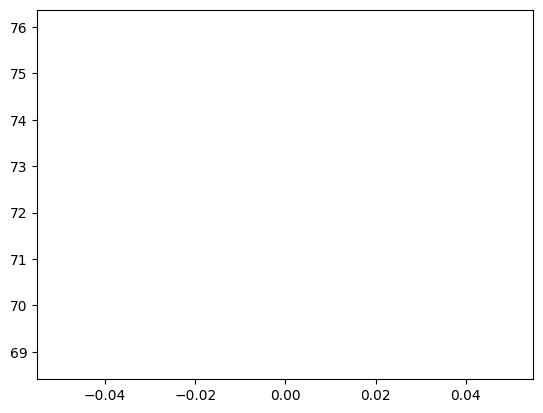



  1%|          | 1000/81532 [01:48<2:19:36,  9.61it/s]

  1%|▏         | 1100/81532 [01:58<2:19:51,  9.59it/s]

  1%|▏         | 1200/81532 [02:08<2:19:16,  9.61it/s]

  2%|▏         | 1300/81532 [02:19<2:20:35,  9.51it/s]

  2%|▏         | 1400/81532 [02:29<2:19:42,  9.56it/s]

  2%|▏         | 1500/81532 [02:40<2:20:21,  9.50it/s]

  2%|▏         | 1600/81532 [02:51<2:20:47,  9.46it/s]

  2%|▏         | 1700/81532 [03:01<2:18:56,  9.58it/s]

  2%|▏         | 1800/81532 [03:11<2:19:10,  9.55it/s]

  2%|▏         | 1900/81532 [03:22<2:18:16,  9.60it/s]

[2.3297350343473996e-05]


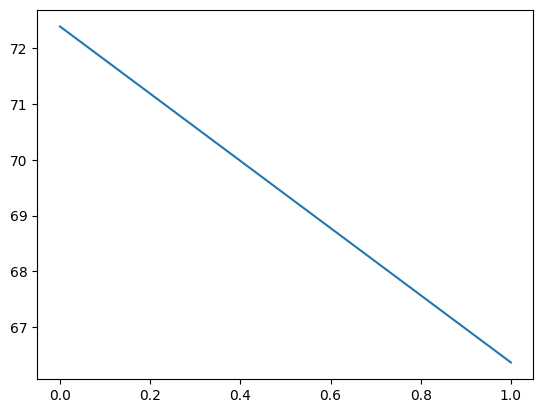



  2%|▏         | 2000/81532 [03:33<2:19:29,  9.50it/s]

  3%|▎         | 2100/81532 [03:43<2:18:47,  9.54it/s]

  3%|▎         | 2200/81532 [03:53<2:18:31,  9.55it/s]

  3%|▎         | 2300/81532 [04:04<2:19:01,  9.50it/s]

  3%|▎         | 2400/81532 [04:14<2:15:40,  9.72it/s]

  3%|▎         | 2500/81532 [04:24<2:15:37,  9.71it/s]

  3%|▎         | 2600/81532 [04:34<2:14:28,  9.78it/s]

  3%|▎         | 2700/81532 [04:44<2:13:18,  9.86it/s]

  3%|▎         | 2800/81532 [04:55<2:16:03,  9.64it/s]

  4%|▎         | 2900/81532 [05:05<2:15:45,  9.65it/s]

[3.3110893032384695e-05]


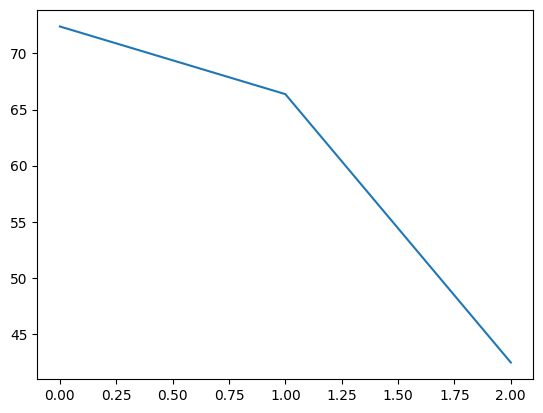



  4%|▎         | 3000/81532 [05:16<2:18:13,  9.47it/s]

  4%|▍         | 3100/81532 [05:27<2:16:28,  9.58it/s]

  4%|▍         | 3200/81532 [05:37<2:16:12,  9.58it/s]

  4%|▍         | 3300/81532 [05:47<2:15:42,  9.61it/s]

  4%|▍         | 3400/81532 [05:57<2:14:40,  9.67it/s]

  4%|▍         | 3500/81532 [06:08<2:15:48,  9.58it/s]

  4%|▍         | 3600/81532 [06:18<2:14:11,  9.68it/s]

  5%|▍         | 3700/81532 [06:28<2:13:12,  9.74it/s]

  5%|▍         | 3800/81532 [06:38<2:12:21,  9.79it/s]

  5%|▍         | 3900/81532 [06:49<2:12:19,  9.78it/s]

[4.292443572129539e-05]


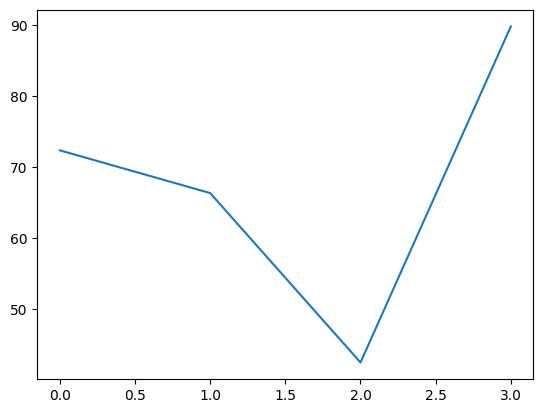



  5%|▍         | 4000/81532 [06:59<2:13:44,  9.66it/s]

  5%|▌         | 4100/81532 [07:10<2:13:31,  9.66it/s]

  5%|▌         | 4200/81532 [07:20<2:14:15,  9.60it/s]

  5%|▌         | 4300/81532 [07:31<2:14:11,  9.59it/s]

  5%|▌         | 4400/81532 [07:41<2:12:43,  9.69it/s]

  6%|▌         | 4500/81532 [07:51<2:12:18,  9.70it/s]

  6%|▌         | 4600/81532 [08:01<2:12:23,  9.68it/s]

  6%|▌         | 4700/81532 [08:12<2:14:37,  9.51it/s]

  6%|▌         | 4800/81532 [08:23<2:13:02,  9.61it/s]

  6%|▌         | 4900/81532 [08:33<2:12:59,  9.60it/s]

[4.999835636212995e-05]


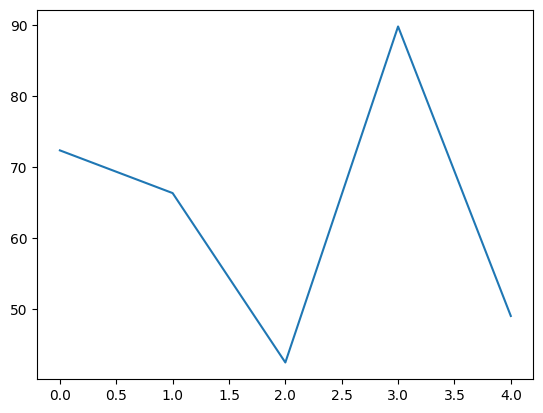



  6%|▌         | 5000/81532 [08:44<2:13:38,  9.54it/s]

  6%|▋         | 5100/81532 [08:54<2:11:56,  9.65it/s]

  6%|▋         | 5200/81532 [09:04<2:10:42,  9.73it/s]

  7%|▋         | 5300/81532 [09:14<2:10:35,  9.73it/s]

  7%|▋         | 5400/81532 [09:24<2:10:39,  9.71it/s]

  7%|▋         | 5500/81532 [09:34<2:08:57,  9.83it/s]

  7%|▋         | 5600/81532 [09:45<2:09:20,  9.78it/s]

  7%|▋         | 5700/81532 [09:55<2:09:47,  9.74it/s]

  7%|▋         | 5800/81532 [10:06<2:12:12,  9.55it/s]

  7%|▋         | 5900/81532 [10:16<2:10:50,  9.63it/s]

[4.996546626360776e-05]


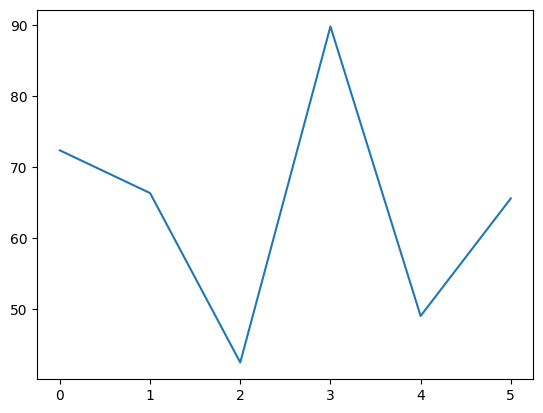



  7%|▋         | 6000/81532 [10:27<2:11:27,  9.58it/s]

  7%|▋         | 6100/81532 [10:37<2:10:56,  9.60it/s]

  8%|▊         | 6200/81532 [10:48<2:11:38,  9.54it/s]

  8%|▊         | 6300/81532 [10:58<2:09:01,  9.72it/s]

  8%|▊         | 6400/81532 [11:08<2:10:36,  9.59it/s]

  8%|▊         | 6500/81532 [11:18<2:09:33,  9.65it/s]

  8%|▊         | 6600/81532 [11:29<2:08:57,  9.68it/s]

  8%|▊         | 6700/81532 [11:39<2:07:59,  9.74it/s]

  8%|▊         | 6800/81532 [11:49<2:06:46,  9.83it/s]

  8%|▊         | 6900/81532 [11:59<2:07:22,  9.76it/s]

[4.989040932827448e-05]


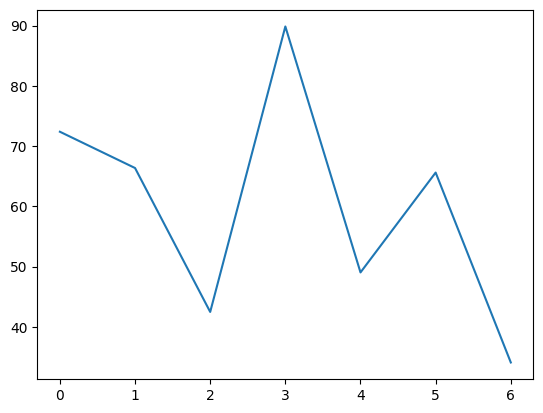



  9%|▊         | 7000/81532 [12:10<2:08:19,  9.68it/s]

  9%|▊         | 7100/81532 [12:20<2:07:19,  9.74it/s]

  9%|▉         | 7200/81532 [12:31<2:09:46,  9.55it/s]

  9%|▉         | 7300/81532 [12:41<2:09:31,  9.55it/s]

  9%|▉         | 7400/81532 [12:52<2:09:06,  9.57it/s]

  9%|▉         | 7500/81532 [13:02<2:07:57,  9.64it/s]

  9%|▉         | 7600/81532 [13:12<2:06:59,  9.70it/s]

  9%|▉         | 7700/81532 [13:22<2:04:50,  9.86it/s]

 10%|▉         | 7800/81532 [13:32<2:05:36,  9.78it/s]

 10%|▉         | 7900/81532 [13:43<2:06:47,  9.68it/s]

[4.977331232778779e-05]


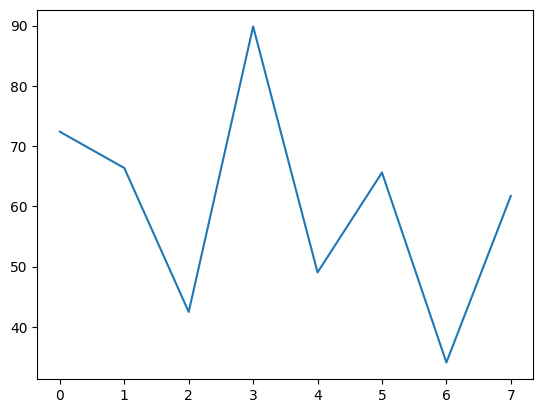



 10%|▉         | 8000/81532 [13:53<2:07:24,  9.62it/s]

 10%|▉         | 8100/81532 [14:04<2:08:00,  9.56it/s]

 10%|█         | 8200/81532 [14:15<2:08:45,  9.49it/s]

 10%|█         | 8300/81532 [14:25<2:06:18,  9.66it/s]

 10%|█         | 8400/81532 [14:35<2:06:18,  9.65it/s]

 10%|█         | 8500/81532 [14:45<2:04:43,  9.76it/s]

 11%|█         | 8600/81532 [14:56<2:06:54,  9.58it/s]

 11%|█         | 8700/81532 [15:06<2:05:14,  9.69it/s]

 11%|█         | 8800/81532 [15:16<2:05:26,  9.66it/s]

 11%|█         | 8900/81532 [15:26<2:04:11,  9.75it/s]

[4.9614373039752113e-05]


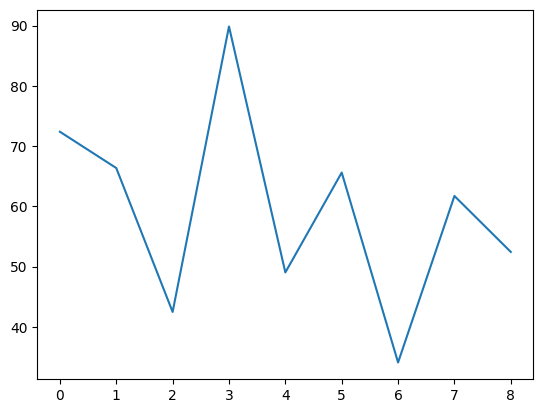



 11%|█         | 9000/81532 [15:37<2:05:03,  9.67it/s]

 11%|█         | 9100/81532 [15:47<2:04:38,  9.68it/s]

 11%|█▏        | 9200/81532 [15:58<2:04:43,  9.67it/s]

 11%|█▏        | 9300/81532 [16:08<2:04:44,  9.65it/s]

 12%|█▏        | 9400/81532 [16:18<2:04:00,  9.69it/s]

 12%|█▏        | 9500/81532 [16:29<2:04:08,  9.67it/s]

 12%|█▏        | 9600/81532 [16:39<2:04:16,  9.65it/s]

 12%|█▏        | 9700/81532 [16:49<2:03:53,  9.66it/s]

 12%|█▏        | 9800/81532 [16:59<2:02:38,  9.75it/s]

 12%|█▏        | 9900/81532 [17:09<2:02:09,  9.77it/s]

[4.941385991367089e-05]


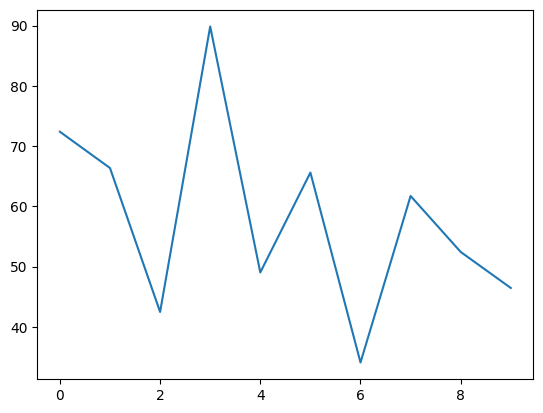



 12%|█▏        | 10000/81532 [17:20<2:02:48,  9.71it/s]

 12%|█▏        | 10100/81532 [17:30<2:02:48,  9.69it/s]

 13%|█▎        | 10200/81532 [17:41<2:03:43,  9.61it/s]

 13%|█▎        | 10300/81532 [17:51<2:03:02,  9.65it/s]

 13%|█▎        | 10400/81532 [18:02<2:03:46,  9.58it/s]

 13%|█▎        | 10500/81532 [18:12<2:04:27,  9.51it/s]

 13%|█▎        | 10600/81532 [18:23<2:03:55,  9.54it/s]

 13%|█▎        | 10700/81532 [18:34<2:04:23,  9.49it/s]

 13%|█▎        | 10800/81532 [18:44<2:02:57,  9.59it/s]

 13%|█▎        | 10900/81532 [18:54<2:01:41,  9.67it/s]

[4.917211161753359e-05]


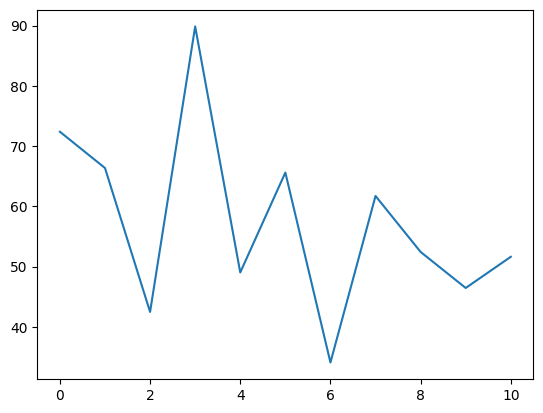



 13%|█▎        | 11000/81532 [19:05<2:03:10,  9.54it/s]

 14%|█▎        | 11100/81532 [19:15<2:03:59,  9.47it/s]

 14%|█▎        | 11200/81532 [19:26<2:03:22,  9.50it/s]

 14%|█▍        | 11300/81532 [19:36<2:02:47,  9.53it/s]

 14%|█▍        | 11400/81532 [19:47<2:02:06,  9.57it/s]

 14%|█▍        | 11500/81532 [19:57<2:00:11,  9.71it/s]

 14%|█▍        | 11600/81532 [20:07<2:01:32,  9.59it/s]

 14%|█▍        | 11700/81532 [20:18<2:01:45,  9.56it/s]

 14%|█▍        | 11800/81532 [20:28<2:01:42,  9.55it/s]

 15%|█▍        | 11900/81532 [20:39<2:01:40,  9.54it/s]

[4.8889536465803284e-05]


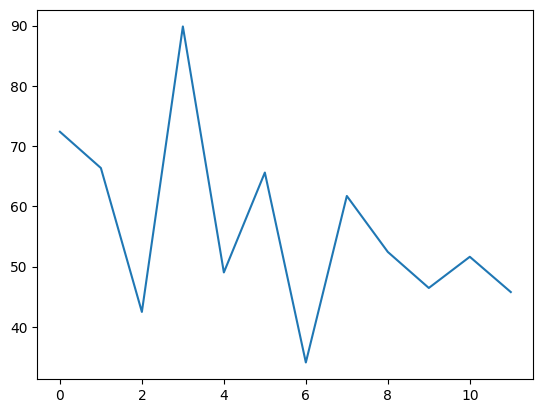



 15%|█▍        | 12000/81532 [20:49<1:59:20,  9.71it/s]

 15%|█▍        | 12100/81532 [20:59<1:58:13,  9.79it/s]

 15%|█▍        | 12200/81532 [21:09<1:57:44,  9.81it/s]

 15%|█▌        | 12300/81532 [21:19<1:58:30,  9.74it/s]

 15%|█▌        | 12400/81532 [21:30<1:58:59,  9.68it/s]

 15%|█▌        | 12500/81532 [21:40<1:59:08,  9.66it/s]

 15%|█▌        | 12600/81532 [21:50<1:58:36,  9.69it/s]

 16%|█▌        | 12700/81532 [22:01<1:59:16,  9.62it/s]

 16%|█▌        | 12800/81532 [22:11<1:59:18,  9.60it/s]

 16%|█▌        | 12900/81532 [22:22<1:58:41,  9.64it/s]

[4.8566611729770804e-05]


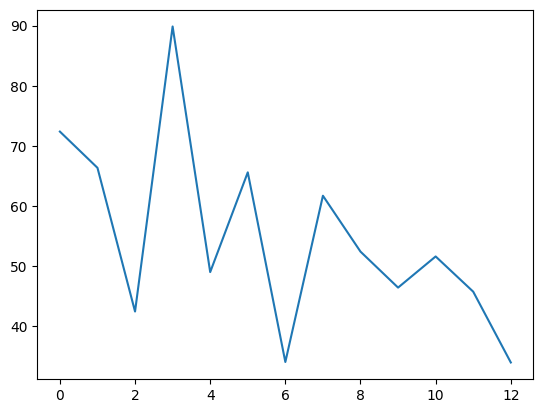



 16%|█▌        | 13000/81532 [22:32<1:59:37,  9.55it/s]

 16%|█▌        | 13100/81532 [22:43<1:58:59,  9.58it/s]

 16%|█▌        | 13200/81532 [22:53<1:58:40,  9.60it/s]

 16%|█▋        | 13300/81532 [23:04<1:58:36,  9.59it/s]

 16%|█▋        | 13400/81532 [23:14<1:59:01,  9.54it/s]

 17%|█▋        | 13500/81532 [23:25<1:58:26,  9.57it/s]

 17%|█▋        | 13600/81532 [23:35<1:57:19,  9.65it/s]

 17%|█▋        | 13700/81532 [23:45<1:58:04,  9.57it/s]

 17%|█▋        | 13800/81532 [23:56<1:58:27,  9.53it/s]

 17%|█▋        | 13900/81532 [24:06<1:57:30,  9.59it/s]

[4.8203882831440404e-05]


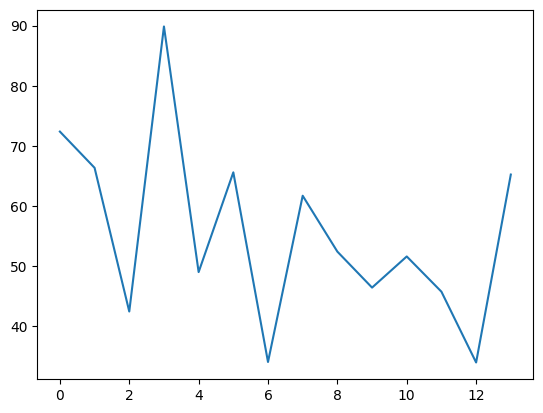



 17%|█▋        | 14000/81532 [24:17<1:58:29,  9.50it/s]

 17%|█▋        | 14100/81532 [24:28<1:59:28,  9.41it/s]

 17%|█▋        | 14200/81532 [24:38<1:58:54,  9.44it/s]

 18%|█▊        | 14300/81532 [24:49<1:57:47,  9.51it/s]

 18%|█▊        | 14400/81532 [24:59<1:56:00,  9.64it/s]

 18%|█▊        | 14500/81532 [25:09<1:54:55,  9.72it/s]

 18%|█▊        | 14600/81532 [25:19<1:53:46,  9.80it/s]

 18%|█▊        | 14700/81532 [25:29<1:53:17,  9.83it/s]

 18%|█▊        | 14800/81532 [25:39<1:53:16,  9.82it/s]

 18%|█▊        | 14900/81532 [25:49<1:53:18,  9.80it/s]


100%|██████████| 3597/3597 [04:28<00:00, 13.38it/s]


({'f1': array([0.24411363, 0.05928746, 0.01177003, 0.02909766, 0.01594567,
       0.04680187, 0.01026557, 0.01917989, 0.0094264 , 0.01108289,
       0.00088626, 0.        , 0.        , 0.        , 0.        ,
       0.00027626, 0.        ])}, {'f1': 0.026949035130563938})
[4.78019624223084e-05]


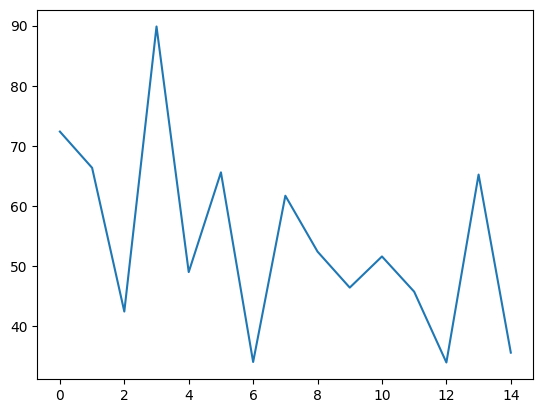



 18%|█▊        | 15000/81532 [30:31<16:56:13,  1.09it/s]

 19%|█▊        | 15100/81532 [30:42<12:25:54,  1.48it/s]

 19%|█▊        | 15200/81532 [30:52<9:15:21,  1.99it/s] 

 19%|█▉        | 15300/81532 [31:03<7:04:03,  2.60it/s]

 19%|█▉        | 15400/81532 [31:14<5:31:42,  3.32it/s]

 19%|█▉        | 15500/81532 [31:24<4:25:03,  4.15it/s]

 19%|█▉        | 15600/81532 [31:34<3:38:59,  5.02it/s]

 19%|█▉        | 15700/81532 [31:44<3:05:42,  5.91it/s]

 19%|█▉        | 15800/81532 [31:54<2:44:01,  6.68it/s]

 20%|█▉        | 15900/81532 [32:05<2:28:49,  7.35it/s]

[4.736152934859075e-05]


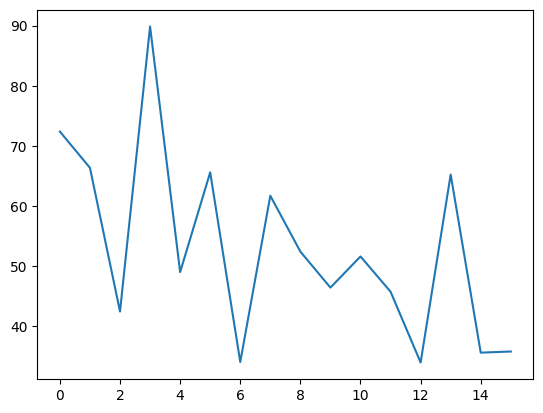



 20%|█▉        | 16000/81532 [32:15<2:18:12,  7.90it/s]

 20%|█▉        | 16100/81532 [32:25<2:09:03,  8.45it/s]

 20%|█▉        | 16200/81532 [32:35<2:03:53,  8.79it/s]

 20%|█▉        | 16300/81532 [32:46<2:01:13,  8.97it/s]

 20%|██        | 16400/81532 [32:56<1:58:01,  9.20it/s]

 20%|██        | 16500/81532 [33:06<1:55:15,  9.40it/s]

 20%|██        | 16600/81532 [33:16<1:53:02,  9.57it/s]

 20%|██        | 16700/81532 [33:27<1:52:19,  9.62it/s]

 21%|██        | 16800/81532 [33:38<1:54:00,  9.46it/s]

 21%|██        | 16900/81532 [33:48<1:53:53,  9.46it/s]

[4.688332750464734e-05]


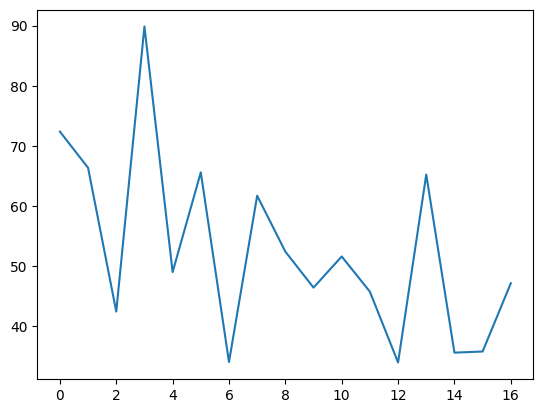



 21%|██        | 17000/81532 [33:59<1:53:28,  9.48it/s]

 21%|██        | 17100/81532 [34:09<1:52:33,  9.54it/s]

 21%|██        | 17200/81532 [34:19<1:52:16,  9.55it/s]

 21%|██        | 17300/81532 [34:30<1:51:10,  9.63it/s]

 21%|██▏       | 17400/81532 [34:40<1:50:21,  9.69it/s]

 21%|██▏       | 17500/81532 [34:50<1:50:06,  9.69it/s]

 22%|██▏       | 17600/81532 [35:00<1:49:20,  9.74it/s]

 22%|██▏       | 17700/81532 [35:10<1:49:00,  9.76it/s]

 22%|██▏       | 17800/81532 [35:21<1:49:08,  9.73it/s]

 22%|██▏       | 17900/81532 [35:31<1:49:32,  9.68it/s]

[4.6368164576539565e-05]


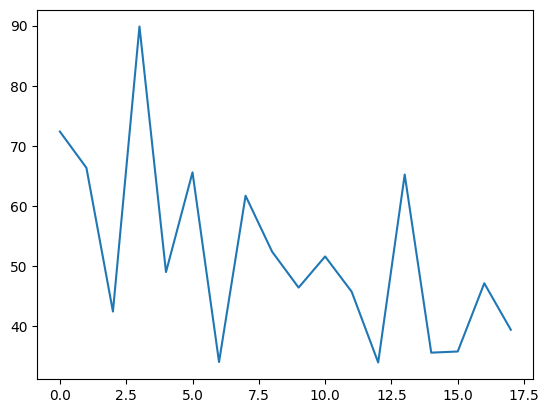



 22%|██▏       | 18000/81532 [35:42<1:50:36,  9.57it/s]

 22%|██▏       | 18100/81532 [35:52<1:49:44,  9.63it/s]

 22%|██▏       | 18200/81532 [36:02<1:49:22,  9.65it/s]

 22%|██▏       | 18300/81532 [36:13<1:49:41,  9.61it/s]

 23%|██▎       | 18400/81532 [36:24<1:50:24,  9.53it/s]

 23%|██▎       | 18500/81532 [36:34<1:50:04,  9.54it/s]

 23%|██▎       | 18600/81532 [36:45<1:49:46,  9.55it/s]

 23%|██▎       | 18700/81532 [36:55<1:49:28,  9.57it/s]

 23%|██▎       | 18800/81532 [37:05<1:48:37,  9.63it/s]

 23%|██▎       | 18900/81532 [37:16<1:49:22,  9.54it/s]

[4.5816910677843116e-05]


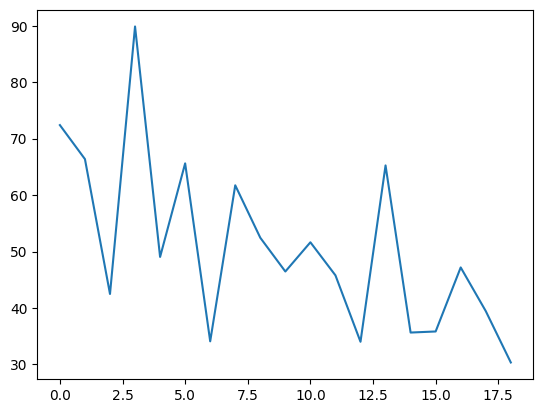



 23%|██▎       | 19000/81532 [37:26<1:48:30,  9.60it/s]

 23%|██▎       | 19100/81532 [37:36<1:47:56,  9.64it/s]

 24%|██▎       | 19200/81532 [37:46<1:46:48,  9.73it/s]

 24%|██▎       | 19300/81532 [37:57<1:47:32,  9.64it/s]

In [ ]:
## from tqdm.auto import tqdm
import matplotlib.pyplot as plt

loss_values = []
ner.train()
it = 1

for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        tokens = batch['input_ids']
        tag = batch['tag']
        alignment = batch['alignment']
        attn_mask = batch['attn_mask']
        crf_mask = batch['train_crf_mask']
        try:
            if not (crf_mask.sum(dim=1) == 0).any():
                outputs = ner(tokens, alignment, tag, attn_mask, crf_mask)
            else:
                continue
        except Exception as e:
            print(tokens, tag, alignment, attn_mask, crf_mask)
            raise e
        loss = -outputs
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if it % 100 == 0: 
            progress_bar.update(100)
        it += 1
        if it % 15000 == 0:
            print(eval_ner(ner, eval_dataloader, labels))
        if ((it % 1000) == 0) or (it == 1):
            print(lr_scheduler.get_last_lr())
            loss_values.append(loss.detach().cpu().item())
            plt.plot(loss_values)
            plt.show()

## Check for updates

In [ ]:
print(1)

In [ ]:
n = 45
print(df=_final.loc[n, 'Sentence'])
tokens =  tokenizer(df_final.loc[n, 'Sentence'])
get_word_alignment(tokens['input_ids'], tokenizer), df_final.loc[n, 'Tag']

In [ ]:
# for row in df_final.iterrows():
#     print(row[1][0], row[1][1])
#     if len(re.findall(r'\w+', row[1][0])) != len(row[1][1]):
#         print(row)
n = 1
# split = " "
# input_text = df_final.loc[n, 'Sentence']
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
# translate_dict = {c: split for c in filters}
# translate_map = str.maketrans(translate_dict)
# input_text = input_text.translate(translate_map)
# seq = input_text.split(split)
special_chars = set('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
for n in tqdm(range(len(df_final))):
    tokens = tokenizer([df_final.loc[n, 'Sentence']])
    for token in tokenizer.batch_decode(tokens['input_ids'][0]):
        if token.count(' ') > 1:
            print(n, token)
        if token.count(' ') == 1 and token.find(' ') == 0:
            print(n, token)
            break
        if len(set(token) & set(special_chars)) != 0 and (re.search('[a-zA-Z0-9]', token) is not None) and token != '<bos>':
            print(n, token)
            break
        
# 

In [ ]:
tokens = tokenizer(['Привет, как у тебя дела молодой человек?'])
for token in tokenizer.batch_decode(tokens['input_ids'][0]):
    if token.count(' ') > 1:
        print(n, '|' + token+ '|')
    if token.count(' ') == 1 and token.find(' ') != 0:
        print(n, '|' + token+ '|')
    if len(set(token) & set(special_chars)) != 0 and (re.search('w+', token) is not None) and token != '<bos>':
        print(n, '|' + token+ '|')

In [ ]:
df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=42)
len(df_train), len(df_test)

# Prepairing dataset

In [ ]:
import json
with open(jp(_, 'train_index_patent_ids.json'), 'r') as f:
    ind_patents = json.loads(f.read())
pm_df = pd.read_parquet(jp(_, 'patent_metadata.parquet'))

In [ ]:
data = pd.DataFrame(data={'publication_number': ind_patents})
pm_df = pd.read_parquet(jp(_, 'patent_metadata.parquet'))

In [ ]:
all_df = pd.read_parquet(jp(_1975, 'all_patents.parquet'))

In [ ]:
data = data.merge(pm_df, how='inner', on='publication_number', copy='False')
data = data.merge(all_df, how='inner', on='publication_number', copy='False')

In [ ]:
import gc
del pm_df
del all_df
gc.collect()

In [ ]:
data.head()

In [ ]:
df = pd.DataFrame(data= {'id': ['1', '2', '4'], 'c': [None, None, None]})
df1 = pd.DataFrame(data= {'id': ['2'], 'c': ['43']})

df.set_index('id', inplace=True)
df1.set_index('id', inplace=True)
df.update(df1)

# Reset the index to move 'id' back to a column
df.reset_index(inplace=True)
del df1

In [ ]:
data.head()

In [ ]:
data.set_index('publication_number', inplace=True)
data["description"] = ''

In [ ]:
data[data['description'] != ''].head()

In [ ]:
import glob
for filename in tqdm(sorted(glob.glob(jp(_, 'patent_data', '*')))):
    f_name = os.path.basename(filename)
    if f_name == 'nan_nan.parquet':
        continue
    year = int(f_name.split('_')[0])
    month = int(f_name.split('_')[1].split('.')[0])
    
    if not (year >= 1991 and year <= 2010):
        continue
        
    print(year, month)
    pat_df = pd.read_parquet(jp(_, 'patent_data', f'{year}_{month}.parquet'), engine='auto', columns=['publication_number', 'description'])
    pat_df.set_index('publication_number', inplace=True)
    data.update(pat_df)
    del pat_df
    gc.collect()
    
    
    
    
    
# for pn, date in tqdm(zip(data['publication_number'], data['publication_date'])):
#     month = date.month
#     year = date.year
#     dt = pd.read_parquet(jp(_, 'patent_data', f'{year}_{month}.parquet'), engine='auto', columns=['publication_number', 'description'])
#     print(dt)
#     break

In [ ]:
data[]

In [ ]:
data.head()

In [ ]:
data.to_parquet('/kaggle/working/1975-2010.parquet')

In [ ]:
batch = ParquetFile(jp(_1975, 'all_patents.parquet'))
# 2. define generator of batches
record = batch.iter_batches(
    batch_size=10
)
# 3. yield pandas/numpy data
for i in range(10):
    print(next(record).to_pandas())

# Loading dataset from prepared file

In [ ]:
from torch.utils.data import Dataset, DataLoader, IterableDataset
from pyarrow.parquet import ParquetFile

In [ ]:
class USPTO_dataset(IterableDataset):
    def __init__(self, data_path, batch_size=10000):
        self.all_batch = ParquetFile(data_path)
        self.batch_size = batch_size
        self.batch_iterator = self.all_batch.iter_batches(
            batch_size=self.batch_size
        )
        self.index = self.batch_size
        self.batch = None
    def __iter__(self):
        return self
    def __next__(self):
        if self.index >= self.batch_size:
            self.batch = next(self.batch_iterator).to_pandas()
            self.batch['publication_date'] = self.batch['publication_date'].dt.strftime('%Y-%m-%d')
            self.batch['filing_date'] = self.batch['filing_date'].dt.strftime('%Y-%m-%d')
            self.index = 0
        self.index += 1
        
        return {k: str(v) if pd.api.types.is_object_dtype(v) else v for k, v in self.batch.iloc[self.index-1].to_dict().items()}

In [ ]:
uspto_dataset = USPTO_dataset(jp('/kaggle/working', '1975-2010.parquet'))
uspto_dataloader = DataLoader(uspto_dataset, batch_size=100, num_workers = 1)
for batch in tqdm(uspto_dataloader):
    continue

# Loss function

In [ ]:
import torch

In [ ]:
def mAP_k(binaries):
    AP_1_k = torch.cumsum(binaries, dim=1) / torch.arange(1, binaries.shape[1]+1)
    mAP_k = ((AP_1_k * binaries).sum(dim=1) / binaries.sum(dim=1)).mean()
    return mAP_k

In [ ]:
def mAPLoss(top_k_preds, top_k_actuals, k):
    binaries = torch.empty((len(top_k_preds), k)) 
    for i, top_k_pred, top_k_actual in enumerate(zip(top_k_preds, top_k_actuals)):
        binaries[i] = torch.tensor([pred == actual for pred, actual in zip(top_k_pred, top_k_actual)], dtype=torch.float16)
    return mAP_k(binaries)

In [ ]:
def Loss(logits, top_k_actuals):
    '''
    logits - torch.tensor (d * L)
    '''
    
    return 

In [ ]:
# def precision(correct, actual):
#     if actual == 0:
#         return 0

#     return correct / actual

# def recall(correct, possible):
#     if possible == 0:
#         return 0

#     return correct / possible

# def f1(p, r):
#     if p + r == 0:
#         return 0

#     return 2 * (p * r) / (p + r)


# def count_correct(t, p, label):
#     label_mask = t == label
#     correct_count = (t[label_mask] = p[label_mask]).sum()
#     return correct_count   
    
    
# def compute_F1_metric(y_true, y_pred, label_nums):
#     labels = torch.arange(label_nums)
#     correct, actual, possible = torch.zeros((label_nums,)), torch.zeros((label_nums,)), torch.zeros((label_nums,))
#     for label in labels:
#         for t, p in zip(y_true, y_pred):
#             correct[label] += sum(count_correct(t, p, label))
#             # multiply by two to account for both type and text
#             possible[label] += (t == label).sum() * 2
#             actual[label] += (p == label).sum() * 2

#     return f1(precision(correct, actual), recall(correct, possible))
    